In [22]:
import csv
from enum import Enum
from functools import partial
from matplotlib import pyplot as plt
import numpy as np

# Typing
from typing import List, Tuple
AttributesRowT = np.ndarray
DatasetRowT = Tuple[AttributesRowT, int]
DatasetT = np.ndarray # TODO

# Code

## Distances

In [23]:
class Distance(Enum):
    MANHATTAN = 1
    EUCLIDEAN = 2
    CHEBYSHEV = np.inf

    def __init__(self, ord):
        self.ord = ord

    def __call__(self, lhs: np.ndarray, rhs: np.ndarray):
        return np.linalg.norm(lhs - rhs, ord=self.ord)


## Kernels

In [24]:
class Kernel(Enum):
    UNIFORM      = partial(lambda x: np.where(x < 1, 0.5, 0))
    TRIANGULAR   = partial(lambda x: np.where(x < 1, 1 - x, 0))
    EPANECHNIKOV = partial(lambda x: np.where(x < 1, 3/4 * (1 - x**2), 0))
    QUARTIC      = partial(lambda x: np.where(x < 1, 15/16 * (1 - x**2)**2, 0))
    TRIWEIGHT    = partial(lambda x: np.where(x < 1, 35/32 * (1 - x**2)**3, 0))
    TRICUBE      = partial(lambda x: np.where(x < 1, 70/81 * (1 - x**3)**3, 0))
    GAUSSIAN     = partial(lambda x: 1/np.sqrt(2 * np.pi) * np.exp(-x**2 / 2))
    COSINE       = partial(lambda x: np.where(x < 1, np.pi/4 * np.cos(np.pi * x / 2), 0))
    LOGISTIC     = partial(lambda x: 1 / (np.exp(x) + 2 + np.exp(-x)))
    SIGMOID      = partial(lambda x: 2/np.pi / (np.exp(x) + np.exp(-x)))

    def __init__(self, f):
        self.f = f

    def __call__(self, x):
        return self.f(x)

## Fixed and variable window kNN calculations

In [25]:
window_zero = 0
window_nz = 0
weight_zero = 0

def calculate_fixed(attributes, values, query, distance_function, kernel_function, window_size):
    global window_zero, window_nz, weight_zero
    if window_size == 0:
        window_zero += 1
        # assert False RE 17 18

        exact_matches = 0
        exact_matches_value = 0

        distances = np.linalg.norm(attributes - query, ord=distance_function.ord, axis=1)
        mask = distances != 0

        exact_matches = np.count_nonzero(mask)

        if exact_matches == 0:
            return values.mean()
        else:
            return values[mask].sum() / exact_matches

    window_nz += 1

    distances = np.linalg.norm(attributes - query, ord=distance_function.ord, axis=1)
    kernel_values = kernel_function(distances / window_size)

    weight_sum = kernel_values.sum()

    if weight_sum == 0:
        weight_zero += 1
        # assert False RE 15
        return values.mean()

    values_sum = np.dot(values, kernel_values)
    return values_sum / weight_sum


def calculate_variable(attributes, values, query, distance_function, kernel_function, neighbours):
    if neighbours == 0:
        assert False

    distances = np.linalg.norm(attributes - query, ord=distance_function.ord, axis=1)
    distances.partition(neighbours)

    window_size = distances[neighbours]

    return calculate_fixed(attributes, values, query, distance_function, kernel_function, window_size)

## F measures

In [26]:
def f_score(precision, recall):
    if precision == 0 or recall == 0:
        return 0
    return 2 * precision * recall / (precision + recall)


def weighted_avg(values: np.ndarray, weights: np.ndarray):
    return np.dot(values, weights) / weights.sum()


def zero_or_div(a, b):
    return np.divide(a, b, 
                     out=np.zeros_like(a, dtype=float), 
                     where=b!=0)


def confusion_stats(confusion: np.ndarray):
    k = confusion.shape[0]

    confusion_diagonal = np.diagonal(confusion)
    rows_sum = confusion.sum(axis=1)
    precision = zero_or_div(confusion_diagonal, confusion.sum(axis=0))
    recall = zero_or_div(confusion_diagonal, rows_sum)
    
    return precision, recall, rows_sum

def macro_f_score(confusion):
    precision, recall, weights = confusion_stats(confusion)
    weighted_precision = weighted_avg(precision, weights)
    weighted_recall = weighted_avg(recall, weights)

    return f_score(weighted_precision, weighted_recall)


def micro_f_score(confusion):
    precision, recall, weights = confusion_stats(confusion)
    f_scores = [f_score(p, r) for p, r in zip(precision, recall)]
    weighted_f = weighted_avg(f_scores, weights)

    return weighted_f

## Reading and preprocessing data

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
def process_row(row: List[str]) -> DatasetRowT:
    *attributes, klass = row
    attributes = np.array(attributes, dtype=float)
    # kmap = {"Iris-setosa": 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
    klass = int(klass) - 1
    return attributes, klass


def normalize(attributes):
    mins = attributes.min(axis=0)
    maxes = attributes.max(axis=0)

    return (attributes - mins) / (maxes - mins)


def read_dataset() -> Tuple[List[str], List[DatasetRowT]]:
    dataset_header: List[str] = []
    dataset: List[DatasetRowT] = []
    dataset_attributes: List[AttributesRowT] = []
    klasses: List[int] = []

    with open('/content/drive/My Drive/Универ/ML/seeds.csv') as dataset_file:
        dataset_reader = csv.reader(dataset_file)
        dataset_header = next(dataset_reader)
        for row in dataset_reader:
            attributes, klass = process_row(row)
            dataset_attributes.append(attributes)
            klasses.append(klass)

    dataset_attributes = np.array(dataset_attributes, dtype=float)
    klasses = np.array(klasses)

    DATASET_LIMIT = len(dataset_attributes)

    return dataset_header, normalize(dataset_attributes[:DATASET_LIMIT]), klasses[:DATASET_LIMIT]

## Leave-One-Out score calculation

In [29]:
def calculate_loo_scores(dataset_attributes, klasses, predictor, klasses_count: int):
    dataset_size = len(dataset_attributes)
    confusion = np.zeros((klasses_count, klasses_count), dtype=int)
    for left in range(dataset_size):
        filtered_attributes = dataset_attributes[np.arange(dataset_size) != left]
        filtered_klasses = klasses[np.arange(dataset_size) != left]
        left_attributes, left_klass = dataset_attributes[left], klasses[left]
        prediction = predictor(filtered_attributes, filtered_klasses, left_attributes)

        confusion[left_klass][int(round(prediction))] += 1

    return macro_f_score(confusion), micro_f_score(confusion)

## Parameters search

In [30]:
def create_predictor(distance, kernel, is_fixed_window, window_size, use_one_hot):
    if use_one_hot:
        if is_fixed_window:
            def predictor(attributes, klasses, query):
                predictions = [
                    calculate_fixed(attributes, np.where(klasses == i, 1, 0), query, distance, kernel, window_size)
                    for i in range(klasses.max() + 1)
                ]
                return np.array(predictions).argmax()
            return predictor
        else:
            def predictor(attributes, klasses, query):
                predictions = [
                    calculate_variable(attributes, np.where(klasses == i, 1, 0), query, distance, kernel, window_size)
                    for i in range(klasses.max() + 1)
                ]
                return np.array(predictions).argmax()
            return predictor

    if is_fixed_window:
        return partial(calculate_fixed, distance_function=distance, kernel_function=kernel, window_size=window_size)
    else:
        return partial(calculate_variable, distance_function=distance, kernel_function=kernel, neighbours=window_size)


def get_window_range(is_fixed_window):
    if is_fixed_window:
       return np.linspace(0, 7, num=50)
    else:
       return np.arange(1, 20)


def pick_best_combination(dataset_attributes, klasses, klasses_count):
    best_combination = None
    best_score = 0

    for distance in list(Distance):
        for kernel in list(Kernel):
            for is_fixed_window in [True, False]:
                for window_size in get_window_range(is_fixed_window):
                    for use_one_hot in [True, False]:
                      predictor = create_predictor(distance, kernel, is_fixed_window, window_size, use_one_hot)
                      macro_score, _ = calculate_loo_scores(dataset_attributes, klasses, predictor, klasses_count)

                      if macro_score > best_score:
                          best_combination = distance, kernel, is_fixed_window, window_size, use_one_hot
                          best_score = macro_score

    return best_combination, best_score

## Plotting

Best result:
f-score: 0.9524805735653242
Distance funcion: Distance.EUCLIDEAN
Ketnel funcion: Kernel.UNIFORM
Fixed window: False
Window size: 4
One-hot encoding: True


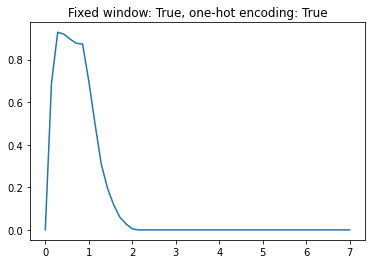

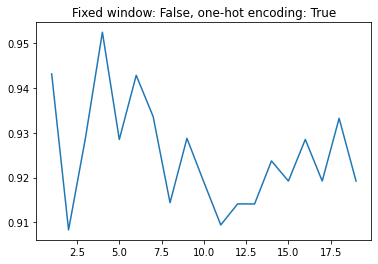

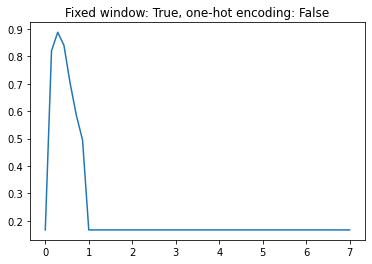

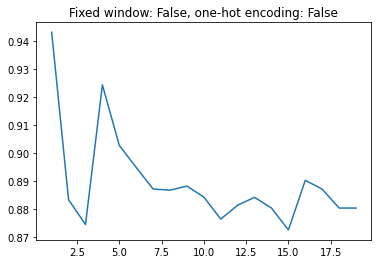

CPU times: user 2min 19s, sys: 59.9 ms, total: 2min 19s
Wall time: 2min 19s


In [31]:
def plot_score(attributes, klasses, distance, kernel, is_fixed_window, use_one_hot):
    window_range = get_window_range(is_fixed_window)
    scores = map(
        lambda window_size: calculate_loo_scores(
            attributes, 
            klasses,
            create_predictor(distance, kernel, is_fixed_window, window_size, use_one_hot),
            klasses.max() + 1)[0],
        window_range)
    
    plt.title('Fixed window: {}, one-hot encoding: {}'.format(is_fixed_window, use_one_hot))
    plt.plot(window_range, list(scores))
    plt.show()


def main():
    _, dataset_attributes, klasses = read_dataset()
    best_combination, best_score = pick_best_combination(dataset_attributes, klasses, klasses.max() + 1) 

    distance, kernel, is_fixed_window, window_size, use_one_hot = best_combination
    
    print('Best result:')
    print('f-score:', best_score)
    print('Distance funcion:', distance)
    print('Ketnel funcion:', kernel)
    print('Fixed window:', is_fixed_window)
    print('Window size:', window_size)
    print('One-hot encoding:', use_one_hot)

    plot_score(dataset_attributes, klasses, distance, kernel, True, True)
    plot_score(dataset_attributes, klasses, distance, kernel, False, True)
    plot_score(dataset_attributes, klasses, distance, kernel, True, False)
    plot_score(dataset_attributes, klasses, distance, kernel, False, False)


%time main()

## PCA (scikit-learn)

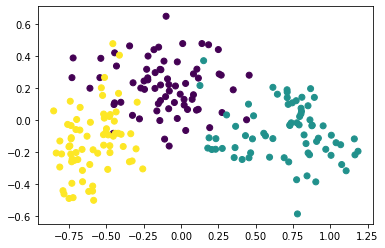

In [32]:
import sklearn.decomposition

def viz():
    pca = sklearn.decomposition.PCA(n_components=2)
    _, dataset_attributes, klasses = read_dataset()
    reduced = pca.fit_transform(dataset_attributes)

    plt.scatter(reduced[:, 0], reduced[:, 1], c = klasses)

viz()

In [33]:
print(window_zero, window_nz, weight_zero)

26040 1770720 10304
